# Read text to dataframe

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

In [327]:
def readfile (filename):
#     target = ["IDENTIFICATION DATA :", "HISTORY OF PRESENT ILLNESS :",
#            "PAST MEDICAL HISTORY :", "SOCIAL HISTORY :", "PHYSICAL EXAMINATION :"]
#     label_list = ["UNKNOWN", "PAST SMOKER", "CURRENT SMOKER", "NON-SMOKER"]
    f = open("./data/Training data/" + filename, "r")
    txt = f.read().splitlines()

    flag = False
    content = ""
    try:
        label = filename.split("_")[0]
        _id = filename.split("_")[2].split('.')[0]
    except:
        label = 0
        _id = filename.split("_")[1].split('.')[0]

    for line in txt:
#         if line in target:
#             flag = True
#             continue
#         elif line[-1:] == ":":
#             flag = False
        if line[-1:] == ":" : 
            flag = True
            continue
        if flag:
            content += (" " + line)
            
    return (content, label, _id)

def files_to_df(files):
    df = pd.DataFrame(columns = ["content", "label", "id"])
    for file in files:
        content, label, _id = readfile(file)
        df = df.append({
            "content": content,
            "label": label,
            "id": _id

        }, ignore_index=True)
    return df

In [328]:
files = listdir("./data/Training data/")
df = files_to_df(files)
# df.to_csv("./data/raw_data.csv", index=False)


# Text Processing

In [329]:
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn import model_selection

# nltk.download("stopwords")
# nltk.download('punkt')
# nltk.download('wordnet')
stopwords = set(stopwords.words('english'))
symbols   = ['.', ',', '’', '“', '”', '"', "''",
             "'", '*', '``', '**', '$', '%', '&', '#',
             '-', '--', "''", '""', '?', '!', ':', ';',
             '(', ')', '[', ']', '{', '}', "/"]
stopwords.update(symbols)

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
clean_content = []

# tokenize, lemmatize, filter with stopwords
for i in range(0, len(df["content"])):
    content = df["content"][i]
    word_list = word_tokenize(content.lower())
    lemmatizer_stemming_content = " ".join(
        stemmer.stem(lemmatizer.lemmatize(word)) for word in word_list if word not in stopwords
    )
    clean_content.append(lemmatizer_stemming_content)

df = df.assign(clean_content = clean_content)

# label Y
encoder = LabelEncoder()
Y = encoder.fit_transform(df["label"])

# assign X
X = clean_content

## Freq words

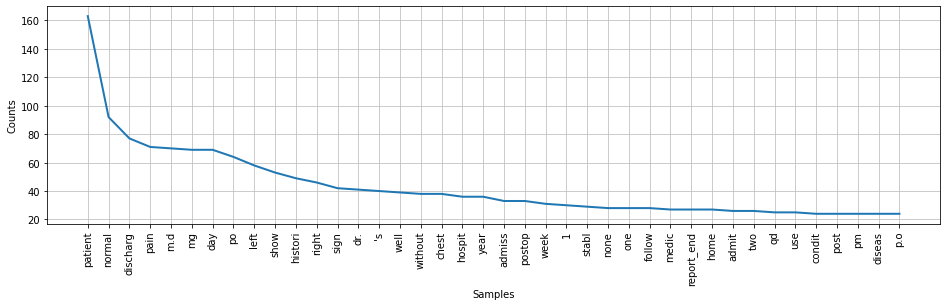

In [330]:
all_words = []
processed = df["clean_content"]
for message in processed:
    words = word_tokenize(message)
    for w in words:
        all_words.append(w)
        
all_words = nltk.FreqDist(all_words)

# show all words freq
fdist_content = nltk.FreqDist(all_words)
plt.figure(figsize=(16,4))
fdist_content.plot(40,cumulative=False)

In [331]:
def find_features(content):
    words = word_tokenize(content)
    features = {}
    for word in word_features:
        features[word] = (word in words)

    return features

# word features
word_features = ["smoke", "smoker", "tobacco"]
content_list = list(zip(X, Y))

seed = 1
np.random.seed = seed
np.random.shuffle(content_list)

# call find_features function for each SMS message
featuresets = [(find_features(text), label) for (text, label) in content_list]

# split data to training, testing
training, testing = model_selection.train_test_split(featuresets, test_size = 0.33, random_state=seed)

In [337]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = zip(names, classifiers)

for name, model in models:
    nltk_model = SklearnClassifier(model)
    nltk_model.train(training)
    accuracy = nltk.classify.accuracy(nltk_model, testing)*100
    print("{} Accuracy: {}".format(name, accuracy))

K Nearest Neighbors Accuracy: 35.714285714285715
Decision Tree Accuracy: 35.714285714285715
Random Forest Accuracy: 35.714285714285715
Logistic Regression Accuracy: 28.57142857142857
SGD Classifier Accuracy: 35.714285714285715
Naive Bayes Accuracy: 14.285714285714285
SVM Linear Accuracy: 28.57142857142857


In [334]:
# Ensemble methods - Voting classifier
from sklearn.ensemble import VotingClassifier

names = ["K Nearest Neighbors", "Decision Tree", "Random Forest", "Logistic Regression", "SGD Classifier",
         "Naive Bayes", "SVM Linear"]

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(),
    SGDClassifier(max_iter = 100),
    MultinomialNB(),
    SVC(kernel = 'linear')
]

models = list(zip(names, classifiers))

nltk_ensemble = SklearnClassifier(VotingClassifier(estimators = models, voting = 'hard', n_jobs = -1))
nltk_ensemble.train(training)
accuracy = nltk.classify.accuracy(nltk_model, testing)*100
print("Voting Classifier: Accuracy: {}".format(accuracy))

Voting Classifier: Accuracy: 28.57142857142857


In [286]:
# make class label prediction for testing set
txt_features, labels = zip(*testing)

prediction = nltk_ensemble.classify_many(txt_features)

In [287]:
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4
           3       0.50      1.00      0.67         5

    accuracy                           0.43        14
   macro avg       0.25      0.38      0.29        14
weighted avg       0.25      0.43      0.31        14



/Library/Python/3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TF-IDF (need to survey how does this work, not yet done)

In [150]:
# need survey how does TF-IDF work, not yet done
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

clean_content = list(df["clean_content"])
tfidf = TfidfVectorizer(min_df = 1, max_df = 1, ngram_range = (1, 2))
features = tfidf.fit_transform(clean_content)

dfidf_df = pd.DataFrame(
    features.todense(),
    columns = tfidf.get_feature_names()
)
# dfidf_df